In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl

## Read all files from 2 sources into 2 dataframes

In [2]:
# patient_df = []
# features = None

# for file in os.listdir('sepsis_data/'):

#     with open('sepsis_data/%s' % (file)) as f:
        
#         if not features:
#             features = f.readline().rstrip('\n').split('|')
#         else:
#             # This skips the headers
#             f.readline()
        
#         for idx, line in enumerate(f):
#             # Append patient ID and time to beginning of data vector
#             pdata = [file.split('.')[0]]
#             pdata.append(idx + 1)
            
#             line = line.rstrip('\n')
#             pdata.extend(line.split('|'))
#             patient_df.append(pdata)

# patient_df = pd.DataFrame(patient_df, columns=['pid', 'time'] + features)
# patient_df.to_csv('patient_df')

In [3]:
patient_df = pd.read_csv('patient_df').drop(columns='Unnamed: 0')
mimic_patient_df = pd.read_csv('sepsis3-MIMICdata/sepsis3-df.csv')

In [10]:
patient_df[patient_df.Unit1 == 1].to_csv('unit1_patients')
patient_df[patient_df.Unit2 == 1].to_csv('unit2_patients')

In [4]:
mimic_patient_df.shape

(11791, 54)

In [5]:
mimic_patient_df.columns

Index(['icustay_id', 'hadm_id', 'excluded', 'intime', 'outtime', 'dbsource',
       'suspected_infection_time_poe', 'suspected_infection_time_poe_days',
       'specimen_poe', 'positiveculture_poe', 'antibiotic_time_poe',
       'blood_culture_time', 'blood_culture_positive', 'age', 'gender',
       'is_male', 'ethnicity', 'race_white', 'race_black', 'race_hispanic',
       'race_other', 'metastatic_cancer', 'diabetes', 'height', 'weight',
       'bmi', 'first_service', 'hospital_expire_flag', 'thirtyday_expire_flag',
       'icu_los', 'hosp_los', 'sepsis_angus', 'sepsis_martin',
       'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit',
       'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple', 'elixhauser_hospital',
       'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'composite_outcome',
       'blood culture', 'suspicion_poe', 'abx_poe', 'sepsis-3', 'sofa>=2'],
      dtype='object')

In [7]:
patient_df.shape

(188453, 43)

In [12]:
patient_df.columns

Index(['pid', 'time', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST',
       'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

## Exploratory Analysis

### 1. Figure out number of patients with sepsis 

In [13]:
patient_df[patient_df.SepsisLabel == 1]['pid'].unique().shape

(279,)

In [14]:
mimic_patient_df[mimic_patient_df['sepsis-3'] == 1]['hadm_id'].unique().shape

(5783,)

In [15]:
mimic_patient_df.hadm_id.unique().shape

(11791,)

## In MIMIC-III sepsis df, half the patients have sepsis. 

### 2. Number of Septic patients between Units

In [ ]:
patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Unit1 == 1)]['pid'].unique().shape

Unit 1: 88 septic patients 

Unit 2: 191 septic patients

### Male Female Ratio

In [16]:
patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Gender == 0)]['pid'].unique().shape

(122,)

122 are female and 157 are male

In [17]:
patient_df[(patient_df.Gender == 0)]['pid'].unique().shape

(2295,)

### Age Range of Septic Patients Between ICUs

In [18]:
ages = patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Unit1 == 1)]['Age'].unique()

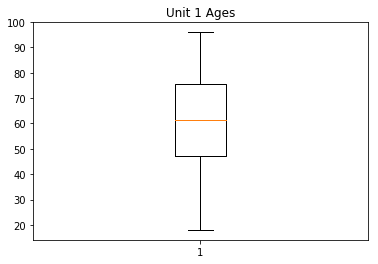

In [19]:
plt.boxplot(ages)
plt.title("Unit 1 Ages")
plt.show()

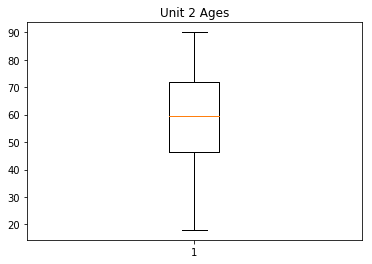

In [20]:
plt.boxplot(patient_df[(patient_df.SepsisLabel == 1) & (patient_df.Unit2 == 1)]['Age'].unique())
plt.title("Unit 2 Ages")
plt.show()


## Let's look at degree of missingness between ICUs

In [21]:
u1_patients = patient_df[patient_df.Unit1 == 1]
u2_patients = patient_df[patient_df.Unit2 == 1]

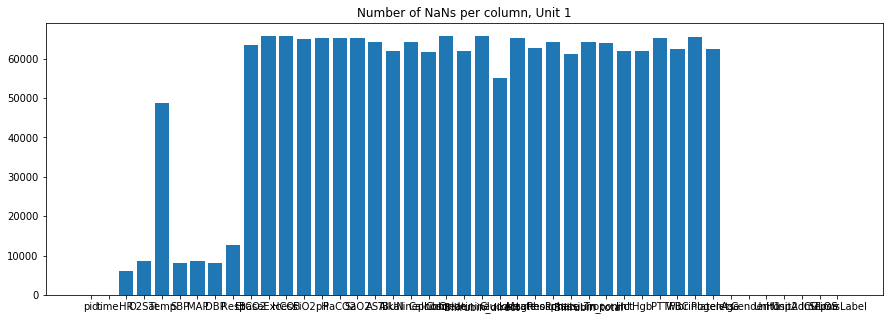

In [22]:
u1_na_count = u1_patients.isna().sum()
plt.figure(figsize=(15,5))
plt.bar(u1_na_count.index, u1_patients.isna().sum().values)
plt.title("Number of NaNs per column, Unit 1")
plt.figure
plt.show()

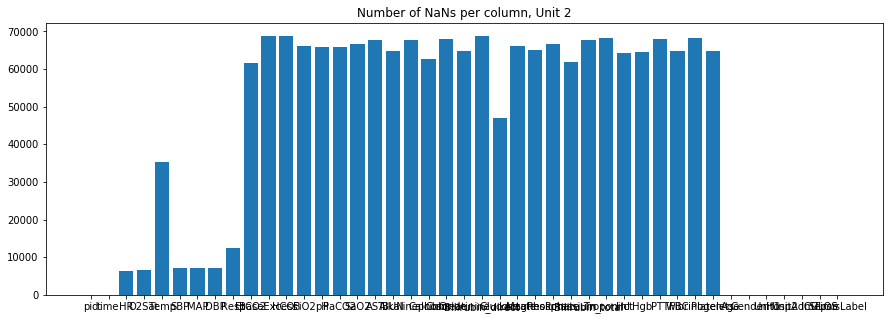

In [23]:
u2_na_count = u2_patients.isna().sum()
plt.figure(figsize=(15,5))
plt.bar(u1_na_count.index, u2_patients.isna().sum().values)
plt.title("Number of NaNs per column, Unit 2")
plt.show()

### Missingness in Unit 1 is a little more than Unit 2 in 2 specific columns

# Let's try simple Logistic Regression on Aggregated Vitals Data

In [24]:
dataset = patient_df.drop(columns=['Age', 'Gender', 'Unit1', 'Unit2', 'ICULOS', 'time', 'HospAdmTime'])

In [25]:
# Create min() mean() and max() features for each patient
y = dataset.groupby(by=['pid']).agg(['max'])['SepsisLabel']
X = dataset.drop(columns=['SepsisLabel']).groupby(by=['pid']).agg(['min', 'mean', 'max'])
X = X[['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP','Resp', 'EtCO2']]

In [26]:
# Replace NaN with 0
X = X.fillna(value=0)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
X_train.shape

(3750, 24)

In [29]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model = model.fit(X_train, y_train.values)

/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
y_pred = model.predict_proba(X_test)

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred[:,1])

0.7257645390070923